# Utility or Risk - Back to optimization

##### Keywords: optimization, decision theory, decision risk, estimation risk, model averaging, bayes risk, true-belief model

In [1]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")
import pymc3 as pm

## Decision Theory

The basic idea behind decision theory is this: predictions (or actions based on predictions) are described by a utility or loss function, whose values can be computed given the observed data.

Indeed one can consider prediction itself as actions to be undertaken with respect to a particular utility.

Remember that there are two key distributions arising from the Bayesian scenario: the posterior $p(\theta \vert D)$ and the posterior-predictive $p(y^* \vert D) = \int d\theta\, p(y^* \vert \theta) p(\theta \vert D)$. Either of these can be used to make decisions: it depends upon what we have information about. If we have information about the true values of params, the posterior might be fine to use. But typically, we dont have this, and are more interested in predictiona from the model, so we formulate the problem in terms of the posterior predictive.

Either way, the components of the decision problem are

1. $a \in A$, available actions for the decision problem
2. $\omega \in \Omega$, a state in the set of states of the world. If $\Omega$ is the set of all future $y$, then $\omega = y^*$, a future $y$. if $\Omega$ is the posterior, then $\omega = \theta$ is a value of a parameter(s)
3. $p(\omega \vert D)$ which tells us out current beliefs about the world. This is either the posterior distribution (for $\theta$) or the posterior predictive distribution (for $y^*$)
4. A utility function $u(a, \omega): A \times \Omega \rightarrow R$ that awards a score/utility/profit to each action $a$ when the state of the universe is $\omega$. This can be also formulated as a risk/loss.

The game then is to maximize the distribution-expected-utility amongst all possible actions a (or minimize the risk).

In other words we first define the distribution-averaged utility:

$$\bar{u}(a) = \int d\omega \, u(a, \omega) \, p(\omega \vert D)$$

We then find the $a$ that maximizes this utility:

$$ \hat{a} = \arg\max_a \bar{u}(a)$$

This action is called the **bayes action**.

The resulting maximized expected utility is given by:

$$\bar{u}(\hat{a}, p) = \bar{u}(\hat{a}) = \int d\omega \, u(\hat{a}, \omega) \, p(\omega \vert D)$$

This maximized utility is sometimes referred to as the entropy function, and an associate **divergence** can be defined:

$$ d(a,p) = \bar{u}(p, p) - \bar{u}(a, p)$$

Then one can think of minimizing $d(a,p)$ with respect to $a$ to get $\hat{a}$, so that this discrepancy can be thought of as a loss function.

### Risk from the posterior predictive

To make this concrete consider the problem in which $\omega$ is a future observation $y^*$. We will then get a posterior predictive distribution with respect to some model $M$ that we shall put into our conditioned-upon variables as well (the reason to do this is that we'll consider later, averaging with respect to sufficiently expressive or true distributions, rather than any particular posterior predictive).

With this in hand we can write:

$$\bar{u}(a) = \int dy^* \, u(a, y^*) \, p(y^* \vert D, M)$$

and

$$\bar{u}(\hat{a}, p) = \bar{u}(\hat{a}) = \int dy^* \, u(\hat{a}, y^*) \, p(y^* \vert D, M)$$


Everything we have talked above works for linear regression ansd other supervised learning: we must just carry an additional $x$ along with us in the formulae:

$$\bar{u}(a(x)) = \int dy^* \, u(a(x), y^*) \, p(y^* \vert x^*, D, M)$$

$$ \hat{a}(x) = \arg\max_a \bar{u}(a(x))$$

## Point prediction

We have not specified above what the action $a$ is. This is on purpose. Sometimes we want to make point predictions. In this case $a$ is a single number. Sometimes we want to find a distribution. And sometimes we want to compare multiple models. We'll see all of these below...

### The squared error loss/utility

The squared error is an example of a risk defined to make a point estimate. Given a posterior predictive distribution, how do you communicate one number to your boss from it? How do you make a point-prediction. (You can think of it as a quadratic approximation to the general class of convex loss functions).

$$l(a, y^*) = (a - y^*)^2$$

The optimal point prediction that minimizes the expected loss (negative expected utility):

$$\bar{l}(a) = \int dy^* \, (a - y^*)^2 \, p(y^* \vert D, M),$$

is the posterior predictive mean:

$$\hat{a} = E_p[y^*].$$

This can be easily seen by differentiating with respect to $a$.

The expected loss then becomes:

$$\bar{l}(\hat{a}) = \int dy^* \, (\hat{a} - y^*)^2 \, p(y^* \vert D, M) = \int dy^* \, (E_p[y^*] - y^*)^2 \, p(y^* \vert D, M) = Var_p[y^*]$$

Using such a loss thus indicates that you only care about the first two moments about the distribution, and that there is no gain to considering things like skewness and kurtosis.

### Custom utility: Stock Market Returns

This is a regression example.

We generate some data to have returns as a function of stock price or trading signals. We generate it as a line with noise, which is perhaps the most unlikely stock market signal...:-)

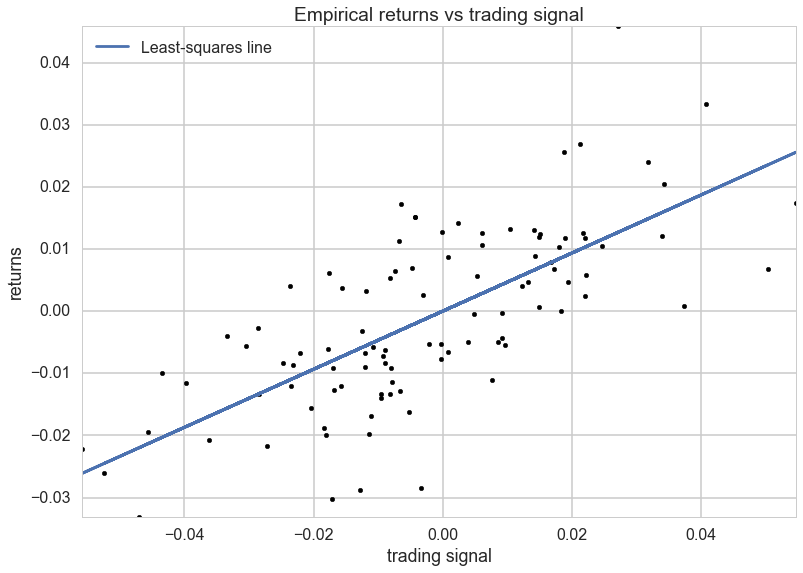

In [6]:
## Code to create artificial data
N = 100
X = 0.025*np.random.randn(N)
Y = 0.5*X + 0.01*np.random.randn(N) 

ls_coef_ = np.cov(X, Y)[0,1]/np.var(X)
ls_intercept = Y.mean() - ls_coef_*X.mean()

plt.scatter(X, Y, c="k")
plt.xlabel("trading signal")
plt.ylabel("returns")
plt.title("Empirical returns vs trading signal")
plt.plot(X, ls_coef_*X + ls_intercept, label = "Least-squares line")
plt.xlim(X.min(), X.max())
plt.ylim(Y.min(), Y.max())
plt.legend(loc="upper left");



A squared-error loss is agnostic to the signage and would penalize a prediction of -0.01 equally as bad a prediction of 0.03:

$$(0.01−(−0.01))^2=(0.01−0.03)^2=0.004$$

Thus we want to define a loss that is sensitive to the difference between the prediction and the posterior-predictive sample.

Notice that the loss is quadratic when the sign is different, as this will create an even higher penalty. There is still a penalty for guessing wrong with the same sign, since you will overcommit money that could have been used more usefully elsewhere.

In [12]:
def stock_loss(stock_return, pred, alpha = 100.):
    if stock_return * pred < 0:
        #opposite signs, not good
        return alpha*pred**2 - np.sign(stock_return)*pred \
                        + abs(stock_return) 
    else:
        return abs(stock_return - pred)

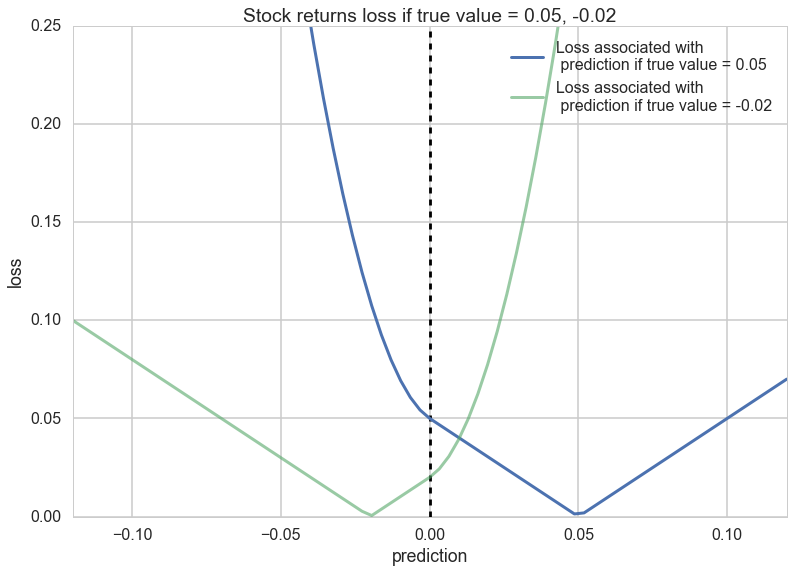

In [13]:
true_value = .05
pred = np.linspace(-.12, .12, 75)

plt.plot(pred, [stock_loss(true_value, _p) for _p in pred], \
        label = "Loss associated with\n prediction if true value = 0.05", lw =3) 
plt.vlines(0, 0, .25, linestyles="--")

plt.xlabel("prediction")
plt.ylabel("loss")
plt.xlim(-0.12, .12)
plt.ylim(0, 0.25)

true_value = -.02
plt.plot(pred, [stock_loss(true_value, _p) for _p in pred], alpha = 0.6, \
        label = "Loss associated with\n prediction if true value = -0.02", lw =3) 
plt.legend()
plt.title("Stock returns loss if true value = 0.05, -0.02");

Notice how the loss changes after you cross the 0 line.

Let us fit our returns model

In [7]:
import pymc3 as pm

with pm.Model() as model:
    std = pm.Uniform("std", 0, 100)
    
    beta = pm.Normal("beta", mu=0, sd=100)
    alpha = pm.Normal("alpha", mu=0, sd=100)
    
    mean = pm.Deterministic("mean", alpha + beta*X)
    
    obs = pm.Normal("obs", mu=mean, sd=std, observed=Y)
    
    trace = pm.sample(100000, step=pm.Metropolis())
    burned_trace = trace[20000:]  

//anaconda/envs/py35/lib/python3.5/site-packages/pymc3/sampling.py:163: UserWarning: Instantiated step methods cannot be automatically initialized. init argument ignored.
  warnings.warn('Instantiated step methods cannot be automatically initialized. init argument ignored.')
100%|██████████| 100000/100000 [00:28<00:00, 3488.01it/s]| 3/100000 [00:00<55:42, 29.92it/s]


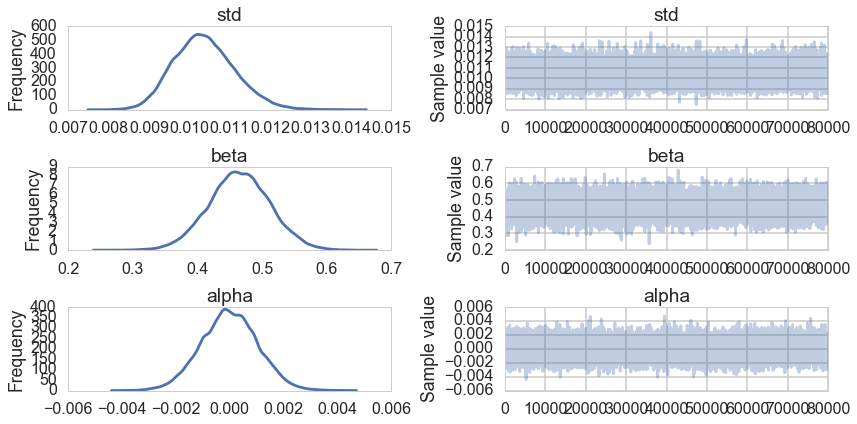

In [9]:
pm.plots.traceplot(trace=burned_trace, varnames=["std", "beta", "alpha"]);

We seem to have converged. Now, the game is to find a point estimate y from the predictive samples at each point(`possible_outcomes`) that minimizes the stock loss, instead of the standard least squares line which is just the mean of the posterior predictive.

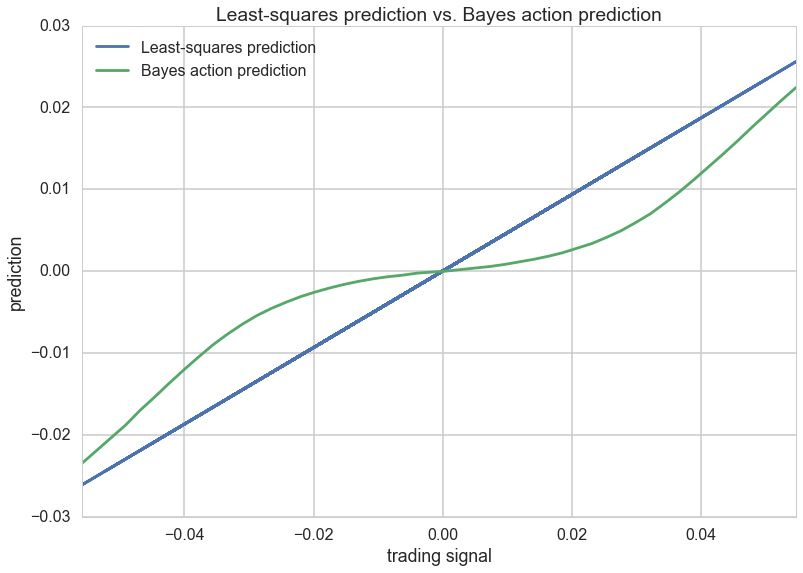

In [11]:
from scipy.optimize import fmin


def stock_loss(price, pred, coef = 500):
    """vectorized for numpy"""
    sol = np.zeros_like(price)
    ix = price*pred < 0 
    sol[ix] = coef*pred**2 - np.sign(price[ix])*pred + abs(price[ix])
    sol[~ix] = abs(price[~ix] - pred)
    return sol

std_samples = burned_trace["std"]
alpha_samples = burned_trace["alpha"]
beta_samples = burned_trace["beta"]

N = std_samples.shape[0]

noise = std_samples*np.random.randn(N) 

possible_outcomes = lambda signal: alpha_samples + beta_samples*signal + noise


opt_predictions = np.zeros(50)
trading_signals =  np.linspace(X.min(), X.max(), 50)
for i, _signal in enumerate(trading_signals):
        _possible_outcomes = possible_outcomes(_signal)
        tomin = lambda pred: stock_loss(_possible_outcomes, pred).mean()
        opt_predictions[i] = fmin(tomin, 0, disp = False)
        
        
plt.xlabel("trading signal")
plt.ylabel("prediction")
plt.title("Least-squares prediction vs. Bayes action prediction")
plt.plot(X, ls_coef_*X + ls_intercept, label ="Least-squares prediction")
plt.xlim(X.min(), X.max())
plt.plot(trading_signals, opt_predictions, label ="Bayes action prediction")
plt.legend(loc="upper left");

The plot above takes the posterior-predictive distribution at each trading signal, applies the risk to it by calculating the integral as a mean over posterior-predictive samples. Then we minimize over the action $a$ which here is a prediction at each trading signal. This is plotted as the green line above. Notice that when the signal is close to 0, our prediction is close to 0, we take no position as its very easy for the sign to be different. Far away from 0, we approach the suared risk more...

## The logarithmic utility function and probabilistic prediction

The logaraithmic utility is used for probabilistic prediction when the unknown state is a future observation $y^*$. This is a subtle point, the squared error loss was used for a non-probabilistic point-prediction from the posterior predictive. But here we want to find our future observations themselves (and the entire distribution of them).

The utility is defined as:

$$u(a, y^*) = log a(y^*),$$

The expected utility then is

$$\bar{u}(a) = \int dy^* \, log(a(y^*))\, p(y^* \vert D, M).$$

The $a$ that maximizes this utility is the posterior-predictive itself!

$$\hat{a}(y^*) = p(y^* \vert D, M)$$

The maximized utility then is:

$$\bar{u}(a) = \int dy^* \, log(p(y^* \vert D, M))\, p(y^* \vert D, M).$$

This is just the negative entropy of the posterior predictive distribution, and the associated divergence is our old friend the KL-divergence.

Our entire analysis here seems to be tautological, but is indeed at the base of model comparison. There we started from the KL-divergence to motivate the use of log scores that went into deriving the AIC, DIC, and WAIC. But decision theory generalizes this notion to the making of any point predictions or probabilistic predictions.

### Single prediction vs multiple prediction

We have so far considered the notion above of predicting a single value from a future dataset. If you had such a dataset (like a test dataset) you can think of this as trying to predict the marginal predictive distribution.

The theoretical derivation is the same for the joint. One can consider the joint to be derived step by step from updated posterior predictives, as the new data points "come in".

In practice we often use n-marginal distributions for the n future points with respect to the "old" dataset D. Clearly the product of n-marginals is not the joint. Butthese methods are commonly used as:

- we might not have all the  new data yet
- the marginal predictives are easier to calculate
- some utilities do not make a difference between the two.



## Predictions with respect to which model/distribution?

So far we have considered the distribution over which we calculate the expectation of the risk to be the posterior predictive distribution of a given model $M$. But if we want to compare models, for example, using the log score as a utility, it does not make sense to do the comparision with respect to one of the distributions being evaluated.

In such a case we consider a "true distribution" of the unseen $y$, which we of-course do not know. But in a model comparison scenario, where we are interested in comparing other distributions, we can do so without knowing the true model. This is the essential idea behind taking the difference in the KL-divergences or equivalent divergences which allow us to create a relative scale on which quantities like the DIC and WAIC can be compared.

Thus we can define the *generalization* utility:

$$ \bar{u}_t(\hat{a}) = \int dy^* u(\hat{a}, y^*) p_t(y^*)$$

where $p_t(y^*)$ is the true predictive distribution. Notice here that we have used $\hat{a}$ because we are already considering the action as optimal with respect to a models posterior predictive.  In other words, for example, in model comparison, we are considering the actions $log(p1)$ and $log(p2)$ to compare to each other, but with respect to the true predictive distribution in computing the overall expected utility. We have seen this method used, in conjunction with marginal posterior-predictives for single points in the definition of the WAIC.

Some researchers actually try and approximate the true distribution by a **true belief** distribution for comparison and other purposes. The idea behind this distribution is that we consider a rich enough model which we believe to capture our phenomenon well after doing posterior predictive checking from it. This might be a non-parametric model like a gaussian process which we shall see soon, or an ensemble model of the type we have seen earlier and which we shall describe in a little more detail below.

This is useful for calculating the difference in predictions between the distribution used and such a true belief distribution: this allows us to see how much worse we are doing. We shall not go further down the line on that, but see Vehtari and Ojanen if you are interested.

### Bayesian Model averaging

Instead, let us briefly dwell on the idea of Bayesian Model averaging. We have seen this earlier, where in a very ad hoc fashion, we weighted models we were comparing by their WAIC weight, and averaged them together. These averaged models typically gave better predictions with more sensible posterior-predictive envelopes.

A simple parametric model is often not enough to provide a rich enough model to serve as a true belief model, or to capture all aspects of our data to make good predictions. Thus we indulge in model averaging:

$$p_{BMA}(y^* \vert x^*, D) = \sum_k p(y^* \vert x^*, D, M_k) p(M_k \vert D)$$

where the averaging is with repect to weights $w_k = p(M_k \vert D)$, the posterior probabilities of the models $M_k$, which is precisely what the Akaike weights purport to be.

We can use the true belief models derived thus at places where we want to use the "true distribution:.

### Where are the models?

Note that you might have chosen expressive and best fit models, but if the true generating process is outside the hypothesis set of the models you are using, then you will never capture the true predictive distribution. This is called misfit or bias. Sometimes, your hypothesis set might be too expressive: this is called overfitting and the true generating process is simpler.

The former is a problem for finding the true belief distribution, and is especially a problem in mechanisms like cross-validation, which we will talk about soon, where holding out data means that we can only fit a less expressive model. The latter needs amelioration by regularization with stronger priors

## Model comparison

The key idea in model comparison is that we will sort our average utilities in some order. The exact values are not important, and may be computed with respect to some true distribution or true-belief distribution $M_{tb}$. Remember that the utility is computed (and maximized) with respect to some model $M_k$ whereas the average of the utility is computed with respect to either the true, or true belief distribution.

$$\bar{u}(M_k, \hat{a}_k) = \int dy^* u(\hat{a}_k, y^*) p(y^* \vert D, M_{tb})$$

where $a_k$ is the optimal prediction under the model $M_k$. Now we compare the actions, that is, we want:

$$\hat{M} = \arg\max_k \bar{u}(M_k, \hat{a}_k)$$

There is no-calibration of these actions. However, calculating the standard error of the difference can be used to see if the difference is significant, as we did with the WAIC score.

For the log score we first get the $M_k$ optimal prediction by

$$\bar{u}(M_k, a_k) = \int dy^* log a_k(y^*) p(y^* \vert D, M_{k})$$

As we know, for this, $a_k = p((y^* \vert D, M_{k})$ which we then plug in to get:

$$\bar{u}(M_k, a_k) = \int dy^* p(y^* \vert D, M_{k}) p(y^* \vert D, M_{tb})$$


We now maximize this over $M_k$. This is equivalent to minimizing the KL-divergence as it is the negative KL divergence upto a $M_k$ independent constant. This is the approach we used to develop model comparison information criteria.

For the squared loss the first step gives us $\hat{a}_k = E_{p(y^* \vert D,M_k)}[y^*]$. We then plug this in to get the expected utility under the true belief model

$$\bar{l}(\hat{a_k}) = \int dy^* \, (\hat{a}_k - y^*)^2 \, p(y^* \vert D, M_{tb}) = \int dy^* \, (E_{p_k}[y^*] - y^*)^2 \, p(y^* \vert D, M_{tb}) = Var_{p_{tb}}[y^*] + (E_{p_{tb}}[y^*] - E_{p_{k}}[y^*])^2$$

Thus if we are model comparing for the squared error, we want the model whose expectation is closest to the true-belief model.

## Risk from the posterior: posterior points

Now consider the problem in which $\omega$, the unknown state of the world is some $\theta$ posterior parameter $\in \Theta$. Then our utility function is of the form $u(a, \theta)$ and our belief about the unknown state of the world is captured by the posterior distribution $p(\theta \vert D, M)$.

The optimal prediction can be found by calculating the expected utility over the posterior:

$$\bar{u}(a) = \int d\theta u(a, \theta) p(\theta \vert D, M)$$

$$\hat{a} = \arg\max_a \bar{u}(a)$$

and then the optimal utility is

$$\bar{u}(\hat{a}) = \int d\theta u(\hat{a}, \theta) p(\theta \vert D, M)$$

Indeed, bayesian decision theory is often formulated with respect to the posterior rather than the posterior predictive, as especially with analytically derivable utilities, it is simple to use sampling to construct these expectations over the posterior.

If we identify the $\theta$ space utility as an average over the sampling distribution:

$$u(a, \theta) = \int u(a, y^*) p(y^* \vert \theta, M) dy^*$$

the two approaches are equivalent and we have merely changed the order of integration.

This approach can be used to give us point estimates from the posterior such as means and medians.